In [ ]:
pip install tensorflow==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
from transformers import BertTokenizer, TFBertForSequenceClassification, create_optimizer
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics: MeanAbsoluteError

In [ ]:
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth',None)
pd.reset_option('display.max_colwidth')

### Number of questions

In [ ]:
data_df = pd.read_csv('Filtered_Data1.csv')

In [ ]:
data_df.head()

,QuestionId,QuestionTitle,QuestionText,MaxScoreAnswerId,MaxScore,MaxScoreAnswerContent,ClosestScoreAnswerId,ClosestScore,ClosestAnswerContent,MinScoreAnswerId,MinScore,MinScoreAnswerContent
0,48543834,How do I reduce a python (docker) image size u...,<p>I am looking for a way to create multistage...,48714519,52,"<p>ok so my solution is using wheel, it lets u...",61879604,18,<p>I recommend the approach detailed in <a hre...,48543945,-20,<p>The docs on this explain exactly how to do ...
1,66745455,next.js build times are slow. How can I make t...,<blockquote>\n<p>I've investigated both the <a...,72777871,22,<p>I've faced the same issue with next.js vers...,72788265,1,<p>I faced the same issue basically. In my cas...,68690600,-19,<p>NextJS compile slow after I try test with p...
2,38132755,ImportError: No module named 'encodings',<p>I recently reinstalled ubuntu and did upgra...,39097003,119,<p>For Python-3 try removing virtual environme...,47157205,9,<p>I had this error during migration to Ubuntu...,48652800,-16,<p>I could also fix this. PYTHONPATH and PYTH...
3,62759505,TypeScript - ts(7053) : Element implicitly has...,"<p>In TypeScript, I declare an interface like ...",62759681,23,<p>The reason for this is because <code>MyDTO<...,62798032,0,"<p>@mhodges, with your suggestions, here is my...",71858283,-16,<p>In the <strong>tsconfig.json</strong> file....
4,50175901,How to extract decision rules (features splits...,<p>I need to extract the decision rules from m...,50324991,20,"<p>It is possible, but not easy. I would recom...",71651016,2,<p>Below is the code fragment which prints all...,50301965,-15,"<p>You need to know the name of your tree, and..."


In [ ]:
data_df['MinScore'] = pd.to_numeric(data_df['MinScore'], errors='coerce')
data_df['ClosestScore'] = pd.to_numeric(data_df['ClosestScore'], errors='coerce')
data_df['MaxScore'] = pd.to_numeric(data_df['MaxScore'], errors='coerce')

In [ ]:
condition = (
    ((data_df['MaxScore'] - data_df['ClosestScore'])>= data_df['ClosestScore']) &
    ((data_df['ClosestScore'] - data_df['MinScore']) >= data_df['MinScore'])
)

filtered_df = data_df[~condition]
filtered_df

,QuestionId,QuestionTitle,QuestionText,MaxScoreAnswerId,MaxScore,MaxScoreAnswerContent,ClosestScoreAnswerId,ClosestScore,ClosestAnswerContent,MinScoreAnswerId,MinScore,MinScoreAnswerContent
126,47060133,Python 3 type hinting for decorator,<p>Consider the following code:</p>\n<pre><cod...,68290080,85,"<p><a href=""https://www.python.org/dev/peps/pe...",47060298,62,<p>You can't use <code>Callable</code> to say ...,71934954,-6,<p>The problem is solved using the <code>decoh...
155,36840438,Binding list to params in Pandas read_sql_quer...,<p>I've been trying to test various methods fo...,36845393,27,<p>Break this up into three parts to help isol...,50760585,14,<p><strong>WARNING!</strong> Although my propo...,63073654,-5,<pre><code>query = 'Select count(*) cnt from T...
159,37558821,How to replace Django's primary key with a dif...,<p>I have a Django web application that uses t...,37605582,24,<h2>The Idea</h2>\n<p>I would recommend to you...,37561570,13,<p>You need to separate two concerns:</p>\n\n<...,37607198,-5,"<p>Keep the <code>AUTO_INCREMENT</code>, but p..."
175,42599498,Numerically stable softmax,<p>Is there a numerically stable way to comput...,42606665,82,<p>The softmax exp(<strong>x</strong>)/sum(exp...,49212689,52,<p>Softmax function is prone to two issues: <s...,42600757,-5,<p>There is nothing wrong with calculating the...
213,63525778,Seeing unknown typescript error in JSConfig.js...,<p>I added a <code>jsconfig.json</code> to my ...,67150439,19,"<p>If you're using Visual Studio Code, just di...",69819594,11,"<p>The <a href=""https://stackoverflow.com/a/67...",63625102,-5,<p>The error is telling you it can't find dote...
...,...,...,...,...,...,...,...,...,...,...,...,...
6680,36787603,What exactly is __weakref__ in Python?,"<p>Surprisingly, there's no explicit documenta...",36789779,86,<p><code>__weakref__</code> is just an opaque ...,36788452,59,"<p>Interestingly enough, the <a href=""https://...",36788031,37,<p>Before we talk about what <code>__weakref__...
6682,75956209,"Error ""'DataFrame' object has no attribute 'ap...",<p>I am trying to append a dictionary to a Dat...,75956237,384,"<p>As of pandas 2.0, <code>append</code> (prev...",76449334,70,<p><strong>Disclaimer:</strong> this answer se...,76132725,43,<p>If you are enlarging a dataframe in a loop ...
6683,69081410,Error [ERR_REQUIRE_ESM]: require() of ES Modul...,"<p>I'm trying to make a <a href=""https://en.wi...",69089164,101,<p>The <code>node-fetch</code> latest version ...,69093538,83,<p>I figured it out. I just had to downgrade <...,69083422,46,<p><code>node-fetch</code> v3 recently stopped...
6685,42609943,What is the use case for `pip install -e`?,<p>When I need to work on one of my pet projec...,59667164,159,<p>I find <code>pip install -e</code> extremel...,68885989,104,<p>For those who don't have time:</p>\n<p>If y...,56528280,51,"<p><a href=""https://pip.pypa.io/en/stable/cli/..."


In [ ]:
data_df = data_df[~data_df.isin(filtered_df)].dropna()
data_df.reset_index(drop=True, inplace=True)

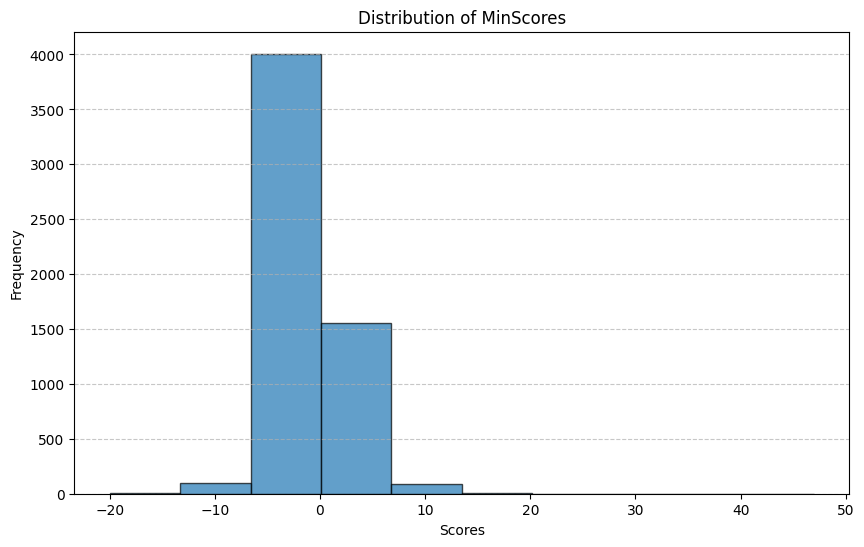

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data_df['MinScore'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of MinScores')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# הצגת הגרף
plt.show()

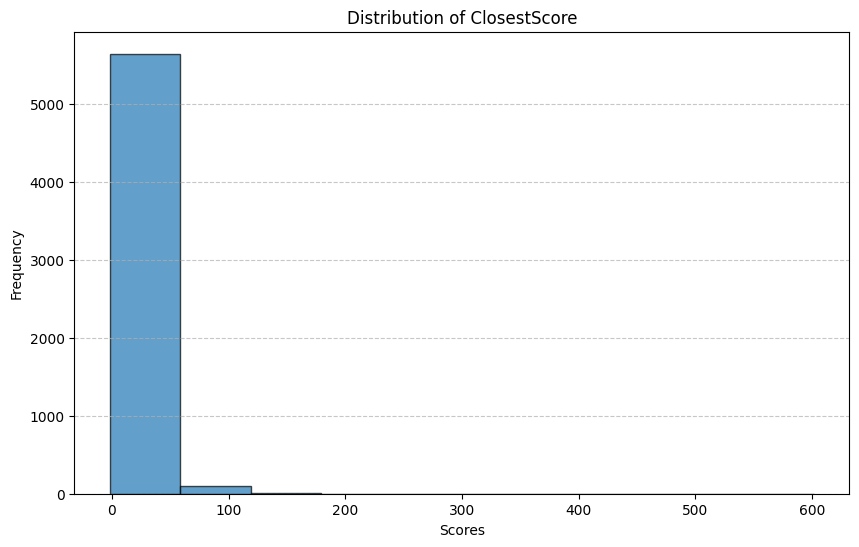

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data_df['ClosestScore'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Distribution of ClosestScore')
plt.xlabel('Scores')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# הצגת הגרף
plt.show()

In [ ]:
transformed_data_list = []
for index, row in data_df.iterrows():
    max_row = {
        'Text': str(row['QuestionTitle']) + str(row['QuestionText'])+str(row['MinScoreAnswerContent']),
        'Score': row['MaxScore'],
        'Grade': 2
    }
    transformed_data_list.append(max_row)

    closest_row = {
        'Text': str(row['QuestionTitle']) + str(row['QuestionText'])+str(row['MinScoreAnswerContent']),
        'Score': row['ClosestScore'],
        'Grade': 1
    }
    transformed_data_list.append(closest_row)

    min_row = {
        'Text': str(row['QuestionTitle']) + str(row['QuestionText'])+str(row['MinScoreAnswerContent']),
        'Score': row['MinScore'],
        'Grade': 0
    }
    transformed_data_list.append(min_row)

data_df = pd.DataFrame(transformed_data_list)

In [ ]:
data_df.head()

,Text,Score,Grade
0,How do I reduce a python (docker) image size u...,52.0,2
1,How do I reduce a python (docker) image size u...,18.0,1
2,How do I reduce a python (docker) image size u...,-20.0,0
3,next.js build times are slow. How can I make t...,22.0,2
4,next.js build times are slow. How can I make t...,1.0,1


In [ ]:
print(data_df.info())
data_df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17295 entries, 0 to 17294
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Text    17295 non-null  object 
 1   Score   17295 non-null  float64
 2   Grade   17295 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 405.5+ KB
None


,Score,Grade
count,17295.000000,17295.00000
mean,31.069384,1.00000
std,69.932930,0.81652
min,-20.000000,0.00000
25%,1.000000,0.00000
50%,10.000000,1.00000
75%,32.000000,2.00000
max,2358.000000,2.00000


In [ ]:
data_df['Grade'].value_counts()

,count
Grade,
2,5765
1,5765
0,5765


### Clean the texts

In [ ]:
import re
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

data_df['Text'] = data_df['Text'].apply(clean_text)

data_df.head(10)

,Text,Score,Grade
0,How do I reduce a python (docker) image size u...,52.0,2
1,How do I reduce a python (docker) image size u...,18.0,1
2,How do I reduce a python (docker) image size u...,-20.0,0
3,next.js build times are slow. How can I make t...,22.0,2
4,next.js build times are slow. How can I make t...,1.0,1
5,next.js build times are slow. How can I make t...,-19.0,0
6,ImportError: No module named 'encodings'I rece...,119.0,2
7,ImportError: No module named 'encodings'I rece...,9.0,1
8,ImportError: No module named 'encodings'I rece...,-16.0,0
9,TypeScript - ts(7053) : Element implicitly has...,23.0,2


In [ ]:
data_df.drop('Score',axis=1,inplace=True)
new_order = ['Text', 'Grade']

# עדכון הסדר של העמודות
data_df = data_df[new_order]
data_df.head()

,Text,Grade
0,How do I reduce a python (docker) image size u...,2
1,How do I reduce a python (docker) image size u...,1
2,How do I reduce a python (docker) image size u...,0
3,next.js build times are slow. How can I make t...,2
4,next.js build times are slow. How can I make t...,1


### Count words (for embedding)

In [ ]:
data_df['word_count'] = data_df['Text'].apply(lambda x: len(x.split()))
data_df['word_count'].describe()

,word_count
count,17295.000000
mean,218.156288
std,169.986675
min,24.000000
25%,119.000000
50%,173.000000
75%,262.000000
max,3239.000000


In [ ]:
num_values_over = (data_df['word_count'] > 700).sum()
num_values_over

327

In [ ]:
total_words = data_df['word_count'].sum()
total_words

3773013

### Check how many unique words

In [ ]:
all_text_combined = ' '.join(data_df['Text'])
all_words_list = all_text_combined.split()
unique_words_set = set(all_words_list)
total_unique_words = len(unique_words_set)
total_unique_words

188174

### How many words appears more than once

In [ ]:
from collections import Counter
word_counts = Counter(all_words_list)
words_more_than_3 = {word: count for word, count in word_counts.items() if count > 3}
print(f"Number of unique words that appear more than once: {len(words_more_than_3)}")

Number of unique words that appear more than once: 56516


In [ ]:
from collections import Counter

word_counts = Counter(words_more_than_3)
most_common_words = word_counts.most_common(15000)
total_frequency_top = sum(freq for _, freq in most_common_words)
total_frequency_all = sum(word_counts.values())
coverage_percentage = (total_frequency_top / total_frequency_all) * 100

print(f"Coverage of the most common 15,000 words: {coverage_percentage:.2f}%")


Coverage of the most common 15,000 words: 90.49%


In [ ]:
data_df.head()

,Text,Grade,word_count
0,How do I reduce a python (docker) image size u...,2,224
1,How do I reduce a python (docker) image size u...,1,224
2,How do I reduce a python (docker) image size u...,0,224
3,next.js build times are slow. How can I make t...,2,384
4,next.js build times are slow. How can I make t...,1,384


In [ ]:
with open("vocab.txt", "w") as f:
    for word, count in most_common_words:
        f.write(f"{word}\n")

In [ ]:
from tokenizers import BertWordPieceTokenizer
tokenizer = BertWordPieceTokenizer()

In [ ]:
tokenizer.train(files=["vocab.txt"], vocab_size=15000, min_frequency=1)

In [ ]:
import os

In [ ]:
save_path = "/content/my_vocab"
os.makedirs(save_path, exist_ok=True)

# שומרים את המילון החדש בתיקייה
tokenizer.save_model(save_path)

['/content/my_vocab/vocab.txt']

In [ ]:
X = data_df['Text'].values
y = data_df['Grade'].values
print(X)
print(y)

['How do I reduce a python (docker) image size using a multi-stage build?I am looking for a way to create multistage builds with python and Dockerfile: For example, using the following images: 1st image: install all compile-time requirements, and install all needed python modules 2nd image: copy all compiled/built packages from the first image to the second, without the compilers themselves (gcc, postgers-dev, python-dev, etc..) The final objective is to have a smaller image, running python and the python packages that I need. In short: how can I \'wrap\' all the compiled modules (site-packages / external libs) that were created in the first image, and copy them in a \'clean\' manner, to the 2nd image. The docs on this explain exactly how to do this. https://docs.docker.com/engine/userguide/eng-image/multistage-build/#before-multi-stage-builds Basically you do exactly what you\'ve said. The magic of multistage build feature though is that you can do this all from one dockerfile. ie: FR

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
from transformers import BertTokenizerFast

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained("/content/my_vocab")

In [ ]:
from transformers import BertConfig, BertForMaskedLM, BertTokenizerFast, Trainer, TrainingArguments

In [ ]:
config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
)

In [ ]:
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
import torch
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=256)

In [ ]:
train_labels = list(y_train)
test_labels = list(y_test)

In [ ]:
# Convert encodings to TensorFlow datasets
def create_tf_dataset(encodings, labels):
    def gen():
        for i in range(len(encodings['input_ids'])):
            yield {key: tf.convert_to_tensor(val[i], dtype=tf.int32) for key, val in encodings.items()}, tf.convert_to_tensor(labels[i], dtype=tf.int32)

    output_signature = (
        {key: tf.TensorSpec(shape=(256,), dtype=tf.int32) for key in encodings.keys()},
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(gen, output_signature=output_signature)


In [ ]:
train_dataset = create_tf_dataset(train_encodings, train_labels)
test_dataset = create_tf_dataset(test_encodings, test_labels)

In [ ]:
train_dataset = train_dataset.shuffle(1000).batch(8).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(8).prefetch(tf.data.experimental.AUTOTUNE)


In [ ]:
batch_size = 16
num_train_steps = len(X_train) // batch_size * 5  # epochs
optimizer, schedule = create_optimizer(
    init_lr=2e-5,
    num_train_steps=num_train_steps,
    num_warmup_steps=0
)

In [ ]:
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

AttributeError: 'Variable' object has no attribute '_distribute_strategy'

In [ ]:
# Calculate steps_per_epoch
steps_per_epoch = len(X_train) // batch_size
validation_steps = len(X_test) // batch_size

# Train the model
history = model.fit(
    train_dataset,
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataset,
    validation_steps=validation_steps
)

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

# Plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()